## Facial keypoints detection

In this task you will create facial keypoint detector based on CNN regressor.


![title](example.png)

### Load and preprocess data

Script `get_data.py` unpacks data — images and labelled points. 6000 images are located in `images` folder and keypoint coordinates are in `gt.csv` file. Run the cell below to unpack data.

In [2]:
# from get_data import unpack
# unpack('facial-keypoints-data.zip')

Now you have to read `gt.csv` file and images from `images` dir. File `gt.csv` contains header and ground truth points for every image in `images` folder. It has 29 columns. First column is a filename and next 28 columns are `x` and `y` coordinates for 14 facepoints. We will make following preprocessing:
1. Scale all images to resolution $100 \times 100$ pixels.
2. Scale all coordinates to range $[-0.5; 0.5]$. To obtain that, divide all x's by width (or number of columns) of image, and divide all y's by height (or number of rows) of image and subtract 0.5 from all values.

Function `load_imgs_and_keypoint` should return a tuple of two numpy arrays: `imgs` of shape `(N, 100, 100, 3)`, where `N` is the number of images and `points` of shape `(N, 28)`.

In [3]:
import warnings
warnings.simplefilter(action='ignore')

In [4]:
import numpy as np
import os
import glob, imageio, csv
from tqdm import tqdm

from skimage.color import gray2rgb
from skimage.io import imread
from skimage.transform import resize

In [5]:
# where is 2 function, which do transformations [(x1, y1), (x2, y2),..] <-> [x1, y1, x2, y2,..]
def pack_points(list_of_point):
    assert len(list_of_point)%2 == 0, 'Len of list should be even'
    n = int(len(list_of_point)/2)
    
    packed_points = [(list_of_point[2*i], list_of_point[2*i+1]) for i in range(n)]
    return packed_points


def unpack_points(packed_points):
    list_of_points = []
    for pair_point in packed_points:
        list_of_points.append(pair_point[0])
        list_of_points.append(pair_point[1])
    return list_of_points

In [6]:
# load images and resize it, returns images (100, 100, 3) and information about original shapes
def load_images(dirname, resize_shape):
    imgs, img_shapes = {}, {}
    
    for im_path in tqdm(glob.glob(dirname+"/images/*.jpg")):
        filename = os.path.basename(im_path)
        img = imageio.imread(im_path)
        if len(img.shape) == 2:
            img = gray2rgb(img)
        
        img_shape = img.shape 
        img = resize(img, resize_shape)
        
        imgs[filename] = img
        img_shapes[filename] = img_shape
    return imgs, img_shapes

# read points' data
def read_points(dirname):
    with open(dirname+"/gt.csv", 'r') as f:
        reader = csv.reader(f)
        points = {}
        next(reader)
        for row in reader:
            im_points = pack_points(list(map(int, row[1:])))
            points[row[0]] = im_points
    return points


In [7]:
# synchronize data about images and points and resize point to relatives values
def sync_and_resize_img_and_points(img_dict, points_dict, img_shape_dict):
    img_list, points_list = [], []
    
    common_keys = set(points_dict.keys()).intersection(set(img_dict.keys()))
    for key in common_keys:
        img = img_dict[key]
        im_points = points_dict[key]
        img_shape = img_shape_dict[key]
        
        im_points = [(point[0]/img_shape[1] - 0.5, point[1]/img_shape[0] - 0.5) for point in im_points]
        
        img_list.append(img)
        points_list.append(im_points)
    return img_list, points_list

In [8]:
def load_imgs_and_keypoints(dirname='data', resize_shape=(100, 100)):
    
    # read images
    faces, img_shapes = load_images(dirname, resize_shape=resize_shape)
    
    # read points
    points = read_points(dirname)
    
    # ordering and resizing img and points in right way
    faces, points = sync_and_resize_img_and_points(faces, points, img_shapes)
    
    return faces, points

imgs, points = load_imgs_and_keypoints()

100%|██████████| 6000/6000 [09:31<00:00, 10.49it/s]


In [9]:
# unpack to required structure
imgs = np.stack(imgs, axis=0)
points = [unpack_points(packed_points) for packed_points in points]

print(f'Faces shape = {imgs.shape}')
print(f'Points shape = {len(points)}')

Faces shape = (6000, 100, 100, 3)
Points shape = 6000


### Visualize data

Let's prepare a function to visualize points on image. Such function obtains two arguments: an image and a vector of points' coordinates and draws points on image (just like first image in this notebook).

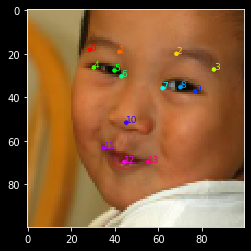

In [13]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.cm import jet, hsv

def visualize_points(img, points):
    plt.imshow(img)
    fig = plt.gcf()
    ax = fig.gca()
    points = pack_points(points)
    for i, point in enumerate(points):
        color = hsv(i/len(points))
        x, y = (point[0]+0.5)*img.shape[1], (point[1]+0.5)*img.shape[0]
        circle = plt.Circle((x, y), 0.8, color=color)
        plt.text(x, y, str(i), color=color, fontsize=9)
        ax.add_artist(circle)
        
    plt.show()
    plt.close()
        
n = 24
visualize_points(imgs[n], points[n])

### Train/val split

Run the following code to obtain train/validation split for training neural network.

In [14]:
from sklearn.model_selection import train_test_split
imgs_train, imgs_val, points_train, points_val = train_test_split(imgs, points, test_size=0.1)

### Simple data augmentation

For better training we will use simple data augmentation — flipping an image and points. Implement function flip_img which flips an image and its' points. Make sure that points are flipped correctly! For instance, points on right eye now should be points on left eye (i.e. you have to mirror coordinates and swap corresponding points on the left and right sides of the face). VIsualize an example of original and flipped image.

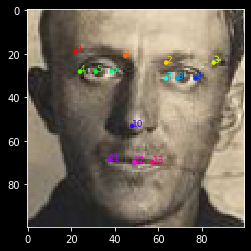

In [16]:
visualize_points(imgs[1], points[1])

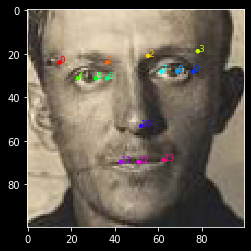

In [17]:
def flip_img(img, points):
    flipped_img = np.flip(img, axis=1)
    flipped_points = [(-1*point[0], point[1]) for point in pack_points(points)]
    flipped_points = [flipped_points[i] for i in (3, 2, 1, 0, 9, 8, 7, 6, 5, 4, 10, 13, 12, 11)]
    flipped_points = unpack_points(flipped_points)
    
    return flipped_img, flipped_points

f_img, f_points = flip_img(imgs[1], points[1])
visualize_points(f_img, f_points)

Time to augment our training sample. Apply flip to every image in training sample. As a result you should obtain two arrays: `aug_imgs_train` and `aug_points_train` which contain original images and points along with flipped ones.

In [18]:
aug_imgs_train = []
aug_points_train = []
for img, im_points in zip(imgs_train, points_train):
    flipped_img, flipped_points = flip_img(img, im_points)
    aug_imgs_train.append(img)
    aug_imgs_train.append(flipped_img)
    aug_points_train.append(im_points)
    aug_points_train.append(flipped_points)
aug_imgs_train = np.stack(aug_imgs_train, axis=0)
aug_points_train = np.array(aug_points_train)

del imgs_train, points_train

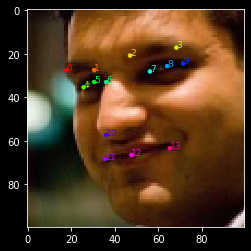

In [19]:
visualize_points(aug_imgs_train[2], aug_points_train[2])

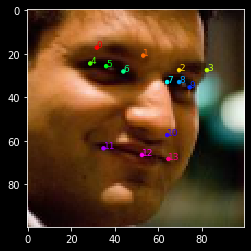

In [20]:
visualize_points(aug_imgs_train[3], aug_points_train[3])

### Network architecture and training

Now let's define neural network regressor. It will have 28 outputs, 2 numbers per point. The precise architecture is up to you. We recommend to add 2-3 (`Conv2D` + `MaxPooling2D`) pairs, then `Flatten` and 2-3 `Dense` layers. Don't forget about ReLU activations. We also recommend to add `Dropout` to every `Dense` layer (with p from 0.2 to 0.5) to prevent overfitting.


In [21]:
points_val = np.array(points_val)

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten,
    Dense, Dropout
)

model = Sequential([
    Conv2D(32, (3, 3), padding='same', activation='relu',  input_shape=(100, 100, 3), data_format='channels_last'), 
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), padding='same', activation='relu'), 
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), padding='same', activation='relu'), 
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), padding='same', activation='relu'), 
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(28, activation='linear')
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #
conv2d_6 (Conv2D)            (None, 100, 100, 32)      896
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 50, 50, 32)        0
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 50, 50, 64)        18496
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 25, 25, 64)        0
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 25, 25, 128)       73856
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 12, 12, 128)       0
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 12, 12, 256)       295168
_______________________________________

Time to train! Since we are training a regressor, make sure that you use mean squared error (mse) as loss. Feel free to experiment with optimization method (SGD, Adam, etc.) and its' parameters.

In [25]:
# ModelCheckpoint can be used for saving model during training.
# Saved models are useful for finetuning your model 
# See keras documentation for more info
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import SGD, Adam

# callback = ModelCheckpoint('model', monitor='val_loss', verbose=0, save_best_only=True)
model_name = 'face_keypoints'
checkpoint = ModelCheckpoint(os.path.join("data/checkpoints", "{model_name}").format(model_name=model_name) + "-{epoch:02d}-{val_loss:.3f}.hdf5", save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)
ea_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5)
opt = Adam()
model.compile(loss='mae', optimizer='Adam')


In [26]:
history = model.fit(x=aug_imgs_train, y=aug_points_train, batch_size=200, epochs=40, verbose=2, 
                    validation_data=(imgs_val, points_val), callbacks=[checkpoint, reduce_lr, ea_stop])

Train on 10800 samples, validate on 600 samples
Epoch 1/40
10800/10800 - 75s - loss: 0.1029 - val_loss: 0.0499
Epoch 2/40
10800/10800 - 14s - loss: 0.0641 - val_loss: 0.0402
Epoch 3/40
10800/10800 - 13s - loss: 0.0524 - val_loss: 0.0398
Epoch 4/40
10800/10800 - 13s - loss: 0.0457 - val_loss: 0.0368
Epoch 5/40
10800/10800 - 13s - loss: 0.0414 - val_loss: 0.0350
Epoch 6/40
10800/10800 - 13s - loss: 0.0378 - val_loss: 0.0337
Epoch 7/40
10800/10800 - 13s - loss: 0.0351 - val_loss: 0.0315
Epoch 8/40
10800/10800 - 13s - loss: 0.0333 - val_loss: 0.0312
Epoch 9/40
10800/10800 - 13s - loss: 0.0321 - val_loss: 0.0297
Epoch 10/40
10800/10800 - 13s - loss: 0.0311 - val_loss: 0.0283
Epoch 11/40
10800/10800 - 13s - loss: 0.0305 - val_loss: 0.0273
Epoch 12/40
10800/10800 - 13s - loss: 0.0297 - val_loss: 0.0264
Epoch 13/40
10800/10800 - 13s - loss: 0.0291 - val_loss: 0.0262
Epoch 14/40
10800/10800 - 13s - loss: 0.0287 - val_loss: 0.0259
Epoch 15/40
10800/10800 - 14s - loss: 0.0283 - val_loss: 0.0255
E

### Visualize results

Now visualize neural network results on several images from validation sample. Make sure that your network outputs different points for images (i.e. it doesn't output some constant).

In [27]:
model.load_weights('data/checkpoints/face_keypoints-34-0.022.hdf5')

In [28]:
pred_points = model.predict(imgs_val)

In [29]:
pred_points_train = model.predict(aug_imgs_train)

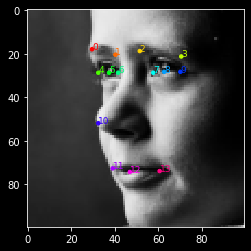

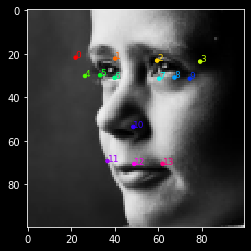

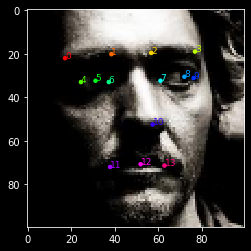

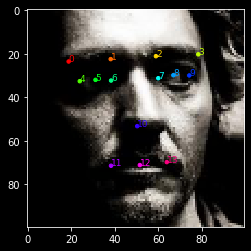

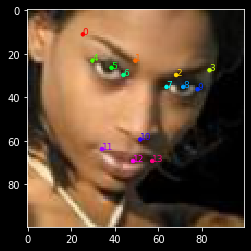

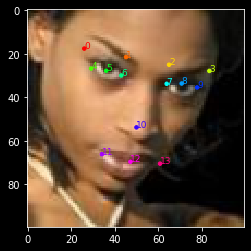

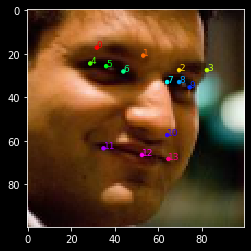

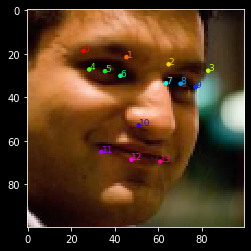

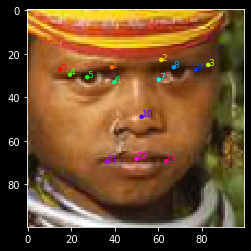

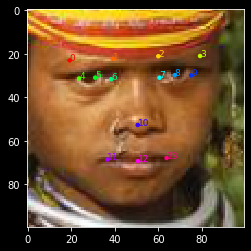

In [30]:
for i in range(5):
    idx = np.random.choice(imgs_val.shape[0])
    visualize_points(aug_imgs_train[idx], aug_points_train[idx])
    visualize_points(aug_imgs_train[idx], pred_points_train[idx])

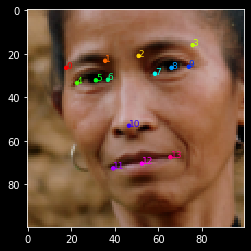

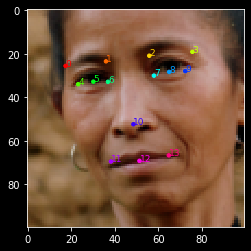

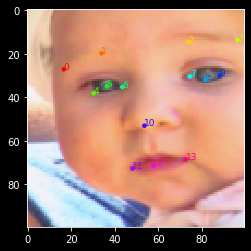

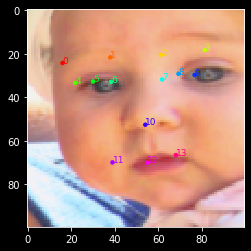

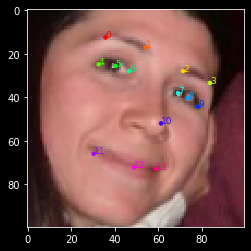

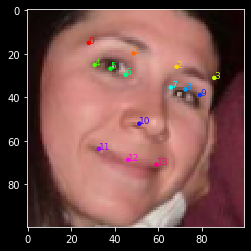

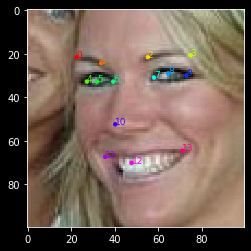

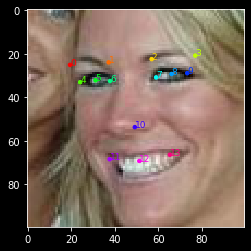

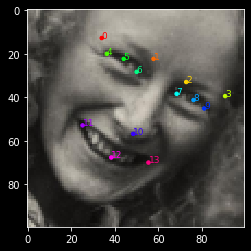

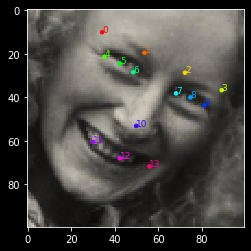

In [31]:
for i in range(5):
    idx = np.random.choice(imgs_val.shape[0])
    visualize_points(imgs_val[idx], points_val[idx])
    visualize_points(imgs_val[idx], pred_points[idx])

In [32]:
model.save('data/checkpoints/model_facial_keypoints.h5')